<a href="https://colab.research.google.com/github/mohamed-ayeb-97/Tandem_solution_for_short_text_clustering/blob/main/Short_Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalation des libraries necessaires

In [ ]:
!pip install -q scikit-learn umap-learn pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.9 MB/s eta 0:00:00


Importation des libraries

In [ ]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import scipy.io
from scipy.optimize import linear_sum_assignment
import ast
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA

import umap
import umap.umap_ as UMAP

from sklearn.manifold import TSNE

from spherical_kmeans import SphericalKmeans

import warnings
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.*")


Fonction de calcul de précision

In [ ]:
def accuracy(y, ypred):

        assert len(y) > 0

        unique_pred = np.unique(ypred)
        unique_true = np.unique(y)

        Nunique_pred = len(np.unique(ypred))
        Nunique_true = len(np.unique(y))

        cm = np.zeros((Nunique_pred, Nunique_true), dtype = np.int32)
        for i in range(Nunique_pred):
            for j in range(Nunique_true):
                idx = np.logical_and(ypred == unique_pred[i], y == unique_true[j])
                cm[i][j] = np.count_nonzero(idx)

        Cmax = np.amax(cm)
        cm = Cmax - cm
        row, col = linear_sum_assignment(cm)

        count = 0
        for i in range(Nunique_pred):
            idx = np.logical_and(ypred == unique_pred[row[i]], y == unique_true[col[i]] )
            count += np.count_nonzero(idx)

        return 1.0*count/len(y)

Importation des données

In [ ]:
# les labels snippet
y_snippet = pd.read_excel('data/SearchSnippets/y_snippet.xlsx', header = None)
y_snippet = y_snippet.values.flatten()

# Importation des HuggingFace Embedding Snippet

output = pd.read_excel('data/output_snippet.xlsx', engine='openpyxl')
embeddings = output['embeddings']
embeddings_array = np.array(embeddings)
processed_data = [ast.literal_eval(embedding_str) for embedding_str in embeddings_array]

x_snippet = np.array(processed_data)

In [ ]:
# les labels stack
y_stack = pd.read_excel('data\stackoverflow\y_stack.xlsx', header = None)
y_stack = y_stack.values.flatten()

# Importation des HuggingFace Embedding stack

output = pd.read_excel('data\output_stack.xlsx', engine='openpyxl')
embeddings = output['embeddings']
embeddings_array = np.array(embeddings)
processed_data = [ast.literal_eval(embedding_str) for embedding_str in embeddings_array]

x_stack = np.array(processed_data)

In [ ]:
# les labels biomed
y_biomed = pd.read_excel('data/Biomedical/y_biomed.xlsx', header = None)
y_biomed = y_biomed.values.flatten()

# Importation des HuggingFace Embedding Biomed

output = pd.read_excel('data/output_biomed.xlsx', engine='openpyxl')
embeddings = output['embeddings']
embeddings_array = np.array(embeddings)
processed_data = [ast.literal_eval(embedding_str) for embedding_str in embeddings_array]

x_biomed = np.array(processed_data)


In [ ]:
def tandem_evaluate(x, y, method):

    if method == "umap":
      n_components_list = np.linspace(100, 320, 50, dtype=int)

    elif method == "acp":
      n_components_list = np.linspace(50, 320, 2, dtype=int)

    best_nmi = {'KMeans': {'nmi': -1, 'accuracy': -1, 'n_components': -1},
                'sKMeans': {'nmi': -1, 'accuracy': -1, 'n_components': -1},
                'KMeans++': {'nmi': -1, 'accuracy': -1, 'n_components': -1}}

    best_accuracy = {'KMeans': {'accuracy': -1,'nmi': -1, 'n_components': -1},
                      'sKMeans': {'accuracy': -1,'nmi': -1, 'n_components': -1},
                      'KMeans++': {'accuracy': -1,'nmi': -1, 'n_components': -1}}

    n_clusters = len(np.unique(y))

    for n_components in n_components_list :

         # Reduction de dimention

        if method == "umap":

          umap_reducer = umap.UMAP(n_components=n_components, n_neighbors = 400, min_dist= 0.25, metric= 'cosine')
          embeding = umap_reducer.fit_transform(x)

        elif method == "acp":

          pca = PCA(n_components=n_components)
          embeding = pca.fit_transform(x)

        # Clustering

        kmeans = KMeans(n_clusters=n_clusters)
        labels_kmeans = kmeans.fit_predict(embeding)
        nmi_kmeans = normalized_mutual_info_score(y, labels_kmeans)
        accuracy_kmeans = accuracy(y, labels_kmeans)

        if nmi_kmeans > best_nmi['KMeans']['nmi']:
          best_nmi['KMeans']['nmi'] = nmi_kmeans
          best_nmi['KMeans']['accuracy'] = accuracy_kmeans
          best_nmi['KMeans']['n_components'] = n_components

        if accuracy_kmeans > best_accuracy['KMeans']['accuracy']:
          best_accuracy['KMeans']['accuracy'] = accuracy_kmeans
          best_accuracy['KMeans']['nmi'] = nmi_kmeans
          best_accuracy['KMeans']['n_components'] = n_components


        spherical_kmeans = SphericalKmeans(n_clusters=n_clusters, max_iter=100)
        spherical_kmeans.fit(embeding)

        labels_skmeans = spherical_kmeans.labels_
        nmi_skmeans = normalized_mutual_info_score(y, labels_skmeans)
        accuracy_skmeans = accuracy(y, labels_skmeans)

        if nmi_skmeans > best_nmi['sKMeans']['nmi']:
          best_nmi['sKMeans']['nmi'] = nmi_skmeans
          best_nmi['sKMeans']['accuracy'] = accuracy_skmeans
          best_nmi['sKMeans']['n_components'] = n_components

        if accuracy_skmeans > best_accuracy['sKMeans']['accuracy']:
          best_accuracy['sKMeans']['accuracy'] = accuracy_skmeans
          best_accuracy['sKMeans']['nmi'] = nmi_skmeans
          best_accuracy['sKMeans']['n_components'] = n_components

        kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++')
        labels_kmeans_pp = kmeans_pp.fit_predict(embeding)
        nmi_kmeans_pp = normalized_mutual_info_score(y, labels_kmeans_pp)
        accuracy_kmeans_pp = accuracy(y, labels_kmeans_pp)

        if nmi_kmeans_pp > best_nmi['KMeans++']['nmi']:
          best_nmi['KMeans++']['nmi'] = nmi_kmeans_pp
          best_nmi['KMeans++']['accuracy'] = accuracy_kmeans_pp
          best_nmi['KMeans++']['n_components'] = n_components


        if accuracy_kmeans_pp > best_accuracy['KMeans++']['accuracy']:
          best_accuracy['KMeans++']['accuracy'] = accuracy_kmeans_pp
          best_accuracy['KMeans++']['nmi'] = nmi_kmeans_pp
          best_accuracy['KMeans++']['n_components'] = n_components

    n_components_kmeans = best_nmi['KMeans']['n_components']
    n_components_sKMeans = best_nmi['sKMeans']['n_components']
    n_components_KMeans_pp = best_nmi['KMeans++']['n_components']

# Print the n_component that gives the best NMI scores for each clustering method

    print(n_components_kmeans)
    print(n_components_sKMeans)
    print(n_components_KMeans_pp)


    nmi_scores = {'KMeans': [], 'sKMeans': [], 'KMeans++': []}
    accuracy_scores = {'KMeans': [], 'sKMeans': [], 'KMeans++': []}

    num_executions = 5

    if method == "umap":

      umap_reducer_kmeans = umap.UMAP(n_components=n_components_kmeans, n_neighbors = 400, min_dist= 0.25, metric= 'cosine')
      X_kmeans = umap_reducer_kmeans.fit_transform(x)

      umap_reducer_skmeans = umap.UMAP(n_components=n_components_sKMeans, n_neighbors = 400, min_dist= 0.25, metric= 'cosine')
      X_skmeans = umap_reducer_skmeans.fit_transform(x)


      umap_reducer_kmeans_pp = umap.UMAP(n_components=n_components_KMeans_pp, n_neighbors = 400, min_dist= 0.25, metric= 'cosine')
      X_kmeans_pp = umap_reducer_kmeans_pp.fit_transform(x)

    elif method == "acp":

      pca_reducer_kmeans = PCA(n_components=n_components_kmeans)
      X_kmeans = pca.fit_transform(x)

      pca_reducer_skmeans  = PCA(n_components=n_components_sKMeans)
      X_skmeans = pca.fit_transform(x)

      pca_reducer_kmeans_pp = PCA(n_components=n_components_KMeans_pp)
      X_kmeans_pp = pca.fit_transform(x)



    # Reduction de Dimension
    for execution in range(num_executions):

        for method in nmi_scores:

        # Clustering
          if method == 'KMeans':

            kmeans = KMeans(n_clusters=n_clusters)
            labels = kmeans.fit_predict(X_kmeans)

            nmi = normalized_mutual_info_score(y, labels)
            acc = accuracy(y, labels)

            nmi_scores[method].append(nmi)
            accuracy_scores[method].append(acc)

          elif method == 'sKMeans':

            kmeans = SphericalKmeans(n_clusters=n_clusters, max_iter=100)
            kmeans.fit(X_skmeans)
            labels = kmeans.labels_

            nmi = normalized_mutual_info_score(y, labels)
            acc = accuracy(y, labels)

            nmi_scores[method].append(nmi)
            accuracy_scores[method].append(acc)


          else:

            kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
            labels = kmeans.fit_predict(X_kmeans_pp)

            nmi = normalized_mutual_info_score(y, labels)
            acc = accuracy(y, labels)
            nmi_scores[method].append(nmi)
            accuracy_scores[method].append(acc)

    print("Mean and Standard Deviation of NMI and Accuracy Scores:")
    print("----------------------------------------------------")
    print("Method      |   NMI              |  Accuracy")
    print("----------------------------------------------------")
    for method in nmi_scores:
        nmi_mean = np.mean(nmi_scores[method])

        nmi_std = np.std(nmi_scores[method])
        acc_mean = np.mean(accuracy_scores[method])
        acc_std = np.std(accuracy_scores[method])
        print(f"{method:<11} | {nmi_mean:.2f} +- {nmi_std:.2f} | {acc_mean:.2f} +- {acc_std:.2f}")
        print("----------------------------------------------------")



In [ ]:
def viz_cluster(x, y):
    n_clusters = len(np.unique(y))

    # Dimensionality Reduction

    # UMAP
    reducer_umap = umap.UMAP(random_state=42, n_neighbors=400, min_dist=0.25, metric='cosine')
    embedding_umap = reducer_umap.fit_transform(x)

    # PCA
    reducer_pca = PCA(n_components=2, random_state=42)
    embedding_pca = reducer_pca.fit_transform(x)

    # t-SNE
    reducer_tsne = TSNE(n_components=2, random_state=42)
    embedding_tsne = reducer_tsne.fit_transform(x)

    # Visualization

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    embeddings = [embedding_pca, embedding_umap, embedding_tsne]
    titles = ['PCA (ACP)', 'UMAP', 't-SNE']

    for ax, embedding, title in zip(axes, embeddings, titles):
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis',
                             alpha=0.5, s=6, edgecolors="black", linewidth=0.25, marker='o')
        ax.set_title(title)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()


ACP

In [ ]:
tandem_evaluate(x_snippet, y_snippet, "acp")

226
117
74
Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.60 +- 0.00 | 0.74 +- 0.00
----------------------------------------------------
sKMeans     | 0.58 +- 0.01 | 0.74 +- 0.02
----------------------------------------------------
KMeans++    | 0.59 +- 0.00 | 0.74 +- 0.00
----------------------------------------------------


In [ ]:
tandem_evaluate(x_biomed, y_biomed, "acp")

205
184
148
Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.45 +- 0.00 | 0.52 +- 0.01
----------------------------------------------------
sKMeans     | 0.42 +- 0.01 | 0.49 +- 0.02
----------------------------------------------------
KMeans++    | 0.44 +- 0.01 | 0.51 +- 0.01
----------------------------------------------------


In [ ]:
tandem_evaluate(x_stack, y_stack, "acp")

55
153
61
Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.70 +- 0.00 | 0.72 +- 0.01
----------------------------------------------------
sKMeans     | 0.67 +- 0.01 | 0.68 +- 0.02
----------------------------------------------------
KMeans++    | 0.70 +- 0.00 | 0.72 +- 0.01
----------------------------------------------------


UMAP


In [ ]:
tandem_evaluate(x_stack, y_stack, "umap")

194
288
167
Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.72 +- 0.00 | 0.76 +- 0.01
----------------------------------------------------
sKMeans     | 0.70 +- 0.01 | 0.67 +- 0.03
----------------------------------------------------
KMeans++    | 0.72 +- 0.01 | 0.75 +- 0.02
----------------------------------------------------


In [ ]:
tandem_evaluate(x_biomed, y_biomed, "umap")

198
185
212
Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.43 +- 0.00 | 0.50 +- 0.01
----------------------------------------------------
sKMeans     | 0.42 +- 0.00 | 0.49 +- 0.01
----------------------------------------------------
KMeans++    | 0.43 +- 0.00 | 0.50 +- 0.01
----------------------------------------------------


In [ ]:
tandem_evaluate(x_snippet, y_snippet, "umap")

Mean and Standard Deviation of NMI and Accuracy Scores:
----------------------------------------------------
Method      |   NMI              |  Accuracy
----------------------------------------------------
KMeans      | 0.68 +- 0.01 | 0.82 +- 0.03
----------------------------------------------------
sKMeans     | 0.65 +- 0.01 | 0.73 +- 0.04
----------------------------------------------------
KMeans++    | 0.69 +- 0.00 | 0.79 +- 0.01
----------------------------------------------------


Data Viz

c:\Users\moham\Desktop\Rag_Mistral\rag\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


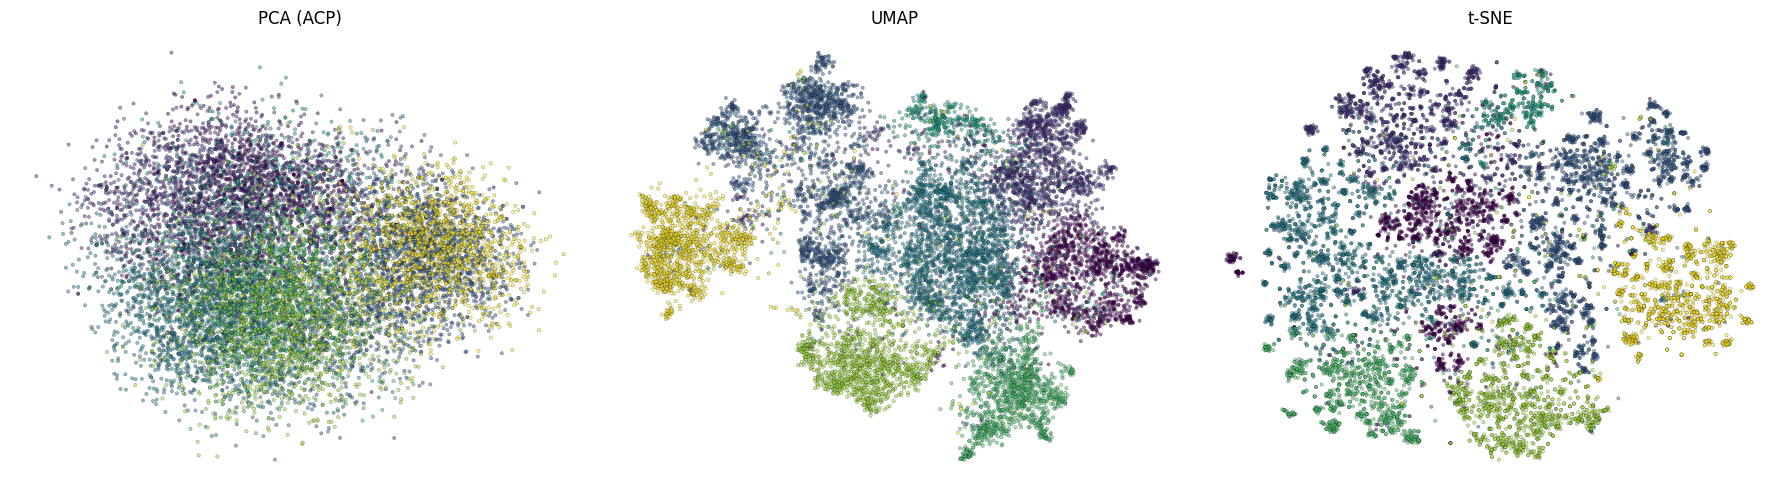

In [ ]:
viz_cluster(x_snippet,y_snippet)